In [1]:
import pylab
from pycbc.frame import read_frame
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries as TS
import bilby
from bilby.gw.conversion import convert_to_lal_binary_neutron_star_parameters, generate_all_bns_parameters
%matplotlib inline

merger = "GW170817"
gps = float(event_gps(merger))

In [2]:
sampling_rate = 4096 # needs to be high enough for the signals found in steps above
duration = 4. # needs to be long enough for the signals found in steps above
start_time = gps-duration/2 # needs to be set so that the segment defined by [start_time, start_time+duration] contains the signal

interferometers = bilby.gw.detector.InterferometerList([])

for ifo_name in ['L1', 'H1', 'V1']:
    ifo = bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('data/'+merger+'_'+ifo_name+'_4KHZ.gwf', sampling_rate, duration, start_time=start_time, channel=ifo_name+':GWOSC-4KHZ_R1_STRAIN')
    ifo.maximum_frequency = 2048
    interferometers.append(ifo)

11:22 bilby INFO    : Reading data from frame file data/GW170817_L1_4KHZ.gwf
11:22 bilby INFO    : Successfully loaded L1:GWOSC-4KHZ_R1_STRAIN.
11:22 bilby INFO    : Reading data from frame file data/GW170817_H1_4KHZ.gwf
11:22 bilby INFO    : Successfully loaded H1:GWOSC-4KHZ_R1_STRAIN.
11:22 bilby INFO    : Reading data from frame file data/GW170817_V1_4KHZ.gwf
11:22 bilby INFO    : Successfully loaded V1:GWOSC-4KHZ_R1_STRAIN.


In [3]:
psd_alpha = 2 * interferometers[0].strain_data.roll_off / 4

L1_psd_data = TS.read('data/'+merger+'_L1_PSD.gwf', 'Strain')
L1_psd = L1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[0].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)

H1_psd_data = TS.read('data/'+merger+'_H1_PSD.gwf', 'Strain')
H1_psd = H1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[1].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)

V1_psd_data = TS.read('data/'+merger+'_V1_PSD.gwf', 'Strain')
V1_psd = V1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[2].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=V1_psd.frequencies.value, psd_array=V1_psd.value)

In [6]:
prior = bilby.gw.prior.BNSPriorDict()

prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=20., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_neutron_star_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short',
    label='GW170817',
    nlive=250,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters
)

11:35 bilby INFO    : No prior given, using default BNS priors in /home/imcmahon/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.
11:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
11:35 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
11:35 bilby INFO    : Running for label 'GW170817', output will be saved to 'short'
11:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy


0it [00:00, ?it/s]

11:35 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f98356ffbb0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
11:35 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:35 bilby INFO    : Using dynesty version 1.0.1
11:35 bilby INFO    : Using the bil

14:37 bilby INFO    : Sampling time: 3:02:14.562406
14:37 bilby INFO    : Reconstructing marginalised parameters.
14:37 bilby INFO    : Cached samples dict out of date, ignoring


  0%|          | 0/11806 [00:00<?, ?it/s]

14:40 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/11806 [00:00<?, ?it/s]

14:40 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/11806 [00:00<?, ?it/s]

14:41 bilby INFO    : Summary of results:
nsamples: 11806
ln_noise_evidence: -362686.975
ln_evidence: -359849.292 +/-  0.568
ln_bayes_factor: 2837.682 +/-  0.568



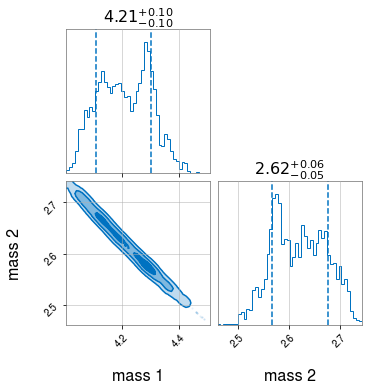

In [7]:
result_short.plot_corner(parameters=["mass_1", "mass_2"])

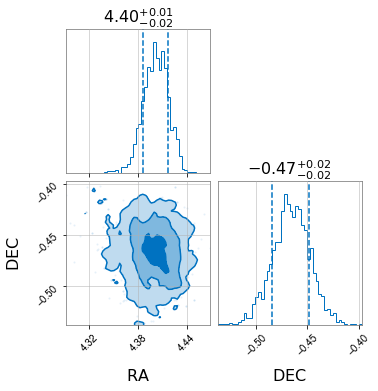

In [8]:
result_short.plot_corner(parameters=["ra", "dec"])

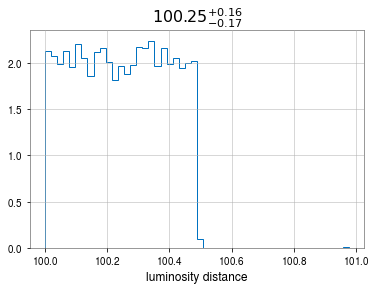

In [9]:
result_short.plot_corner(parameters=["luminosity_distance"])

In [ ]:
prior = bilby.gw.prior.BNSPriorDict()

prior["ra"] = bilby.core.prior.Gaussian(name="ra", mu=3.44616, sigma=0.000005)
prior["dec"] = bilby.core.prior.Gaussian(name="dec", mu=-0.40808, sigma=0.000005)
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=20., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_neutron_star_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short',
    label='GW170817',
    nlive=250,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters
)

In [ ]:
result_short.plot_corner(parameters=["mass_1", "mass_2"])

In [ ]:
result_short.plot_corner(parameters=["ra", "dec"])

In [ ]:
result_short.plot_corner(parameters=["luminosity_distance"])